# TP de Video Processing

## Importation des modules

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import calendar
import time

## **Question A**
Partant de deux frames F1 et F2 où F2 succède à F1 dans le temps, estimez par une méthode pixel-wise les vecteurs de mouvements des pixels de la frame F1 vers F2 (en admettant l’hypothèse de l’intensité constante).

## Chargement des frames

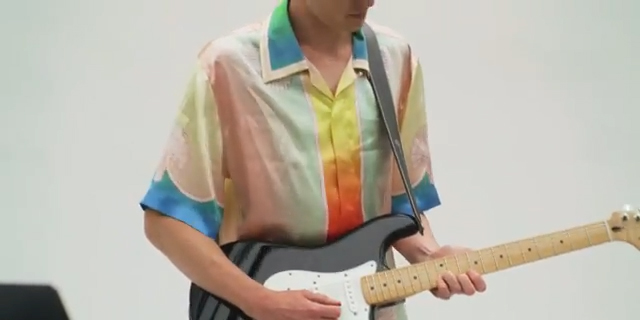

In [2]:
img1 = Image.open("images/LF016.jpg")
img2 = Image.open("images/LF017.jpg")
img1

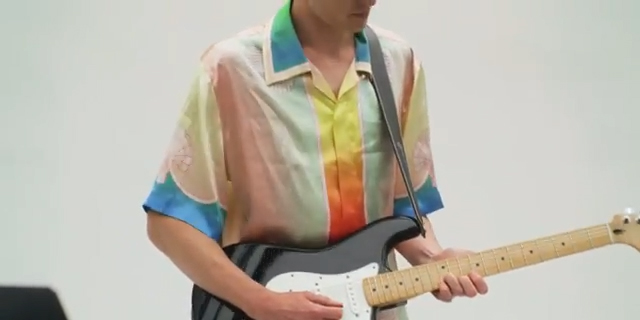

In [3]:
img2

## Création des nd arrays associés aux images

In [4]:
frame_array_1 = np.asarray(img1)
frame_array_2 = np.asarray(img2)
# Vérification 
assert frame_array_1.shape == frame_array_2.shape

## Fonction qui mesure l'écart entre 2 pixels

Il s'agit ici d'appliquuer la distance de Manhattan (ou $\lVert.\lVert_1$) entre deux vecteurs qui sont dans ce cas des pixels en RGB.

In [5]:
def get_absolute_diff_sum(pixel_a, pixel_b):
    return (abs((pixel_a).astype(int) - (pixel_b).astype(int))).sum()

## Déterminer les vecteurs de mouvement

### Déterminer le vecteur au niveau d'un pixel

La fonction ci-dessous va prendre un pixel aux coordonnées `x,y` de la `frame_1` et va chercher dans un voisinage de taille `max_distance` (autour de `(x,y)` )  un pixel de la `frame_2` un pixel ayant une luminescence (une valeur RGB) la plus proche.

In [6]:
def get_closer_pixel(frame_array_1,frame_array_2,x,y, max_distance):
    
    best_pixel_coord = None
    best_pixel = None
    pixel_to_find = frame_array_1[x][y]
    # On cherche d'abord les pixels les plus éloignées en partant d'une distance de `max_distance`
    for current_distance in range(max_distance,-1,-1):
        # On fixe les limites d'abscisse et d'ordonnée du tableau
        x_left_bound = max(0,x-current_distance)
        x_right_bound = min(frame_array_1.shape[0],x+current_distance+1)
        y_bottom_bound,y_top_bound =max(0,y-current_distance),min(frame_array_1.shape[1],y+current_distance+1)
        for x_neigbour in range(x_left_bound,x_right_bound):
            for y_neigbour in range(y_bottom_bound,y_top_bound):
                
                if((abs(x_neigbour-x) + abs(y_neigbour-y)) == current_distance):
                    neigbour_pixel = frame_array_2[x_neigbour][y_neigbour]
                    pixel_diff_sum = get_absolute_diff_sum(neigbour_pixel, pixel_to_find)
                    need_to_change = (best_pixel_coord is None)
                    # On vérifie s'il y a une meilleure proximité en comparaison du pixel précédent
                    need_to_change = need_to_change or (pixel_diff_sum <= get_absolute_diff_sum(best_pixel, pixel_to_find))
                    if(need_to_change):
                        # On met à jour les coordonnées dans le cas ou un pixel de la frame_2 est meilleur candidat que le précédent.
                        best_pixel_coord = x_neigbour,y_neigbour
                        best_pixel = neigbour_pixel
        
    return best_pixel_coord
    

Après avoir déterminer le pixel de la frame 2 le plus proche de celui de la frame 1 on renvoie un tuple qui correspond à un vecteur de mouvement.

In [7]:
def get_move_vector(frame_array_1,frame_array_2,x,y,step):
    new_x, new_y = get_closer_pixel(frame_array_1,frame_array_2,x,y,step)
    return new_x-x, new_y-y

### Déterminer les vecteurs de mouvement au niveau de tous les pixels de la frame

Le but va être de générer deux ndarrays u et v. Ces deux arrays correspondent respectivement aux coordonées directionnelles de chaque point de la frame.
u va représenter les abcisses de chaque point et v les ordonnées. 

In [9]:
def generate_move_vectors(frame_array_1,frame_array_2,step):
    count =0
    u = np.ndarray(shape=frame_array_1.shape[0:2])
    u.fill(0.)
    v = np.ndarray(shape=frame_array_1.shape[0:2])
    v.fill(0.)
    total_count = frame_array_1.shape[0]*frame_array_1.shape[1]
    first = time.time()
    for x in range(frame_array_1.shape[0]):
        for y in range(frame_array_1.shape[1]):
            if(count == total_count//100):
                second = time.time()
                estimated_time = (second -first)*100
                print(f'{int(estimated_time)//60} minutes and {int(estimated_time)%60} seconds left ')
            vector= get_move_vector(frame_array_1,frame_array_2,x,y,step)
            u[x][y]= vector[0]
            v[x][y]= vector[1]
            count+=1
    return u,v


## Afficher les vecteurs de mouvement

Ensuite nous générons les meshgrids ainsi que les vecteurs de mouvement u et v.

In [10]:
STEP = 5
block_size = 5
def compute_movement_vectors(frame_array_1,frame_array_2):
    u,v = generate_move_vectors(frame_array_1,frame_array_2,STEP)
    u =  u[::block_size,::block_size]
    v = v[::block_size,::block_size]
    x =  np.arange(frame_array_1.shape[1])  
    y = np.arange(frame_array_1.shape[0]-1,-1,-1) 
    X, Y = np.meshgrid(x[::block_size], y[::block_size])
    return X,Y, u, v

X,Y, u, v = compute_movement_vectors(frame_array_1,frame_array_2)

2 minutes and 16 seconds left 


Il faut maintenant afficher via Quiver l'ensemble des vecteurs de mouvements

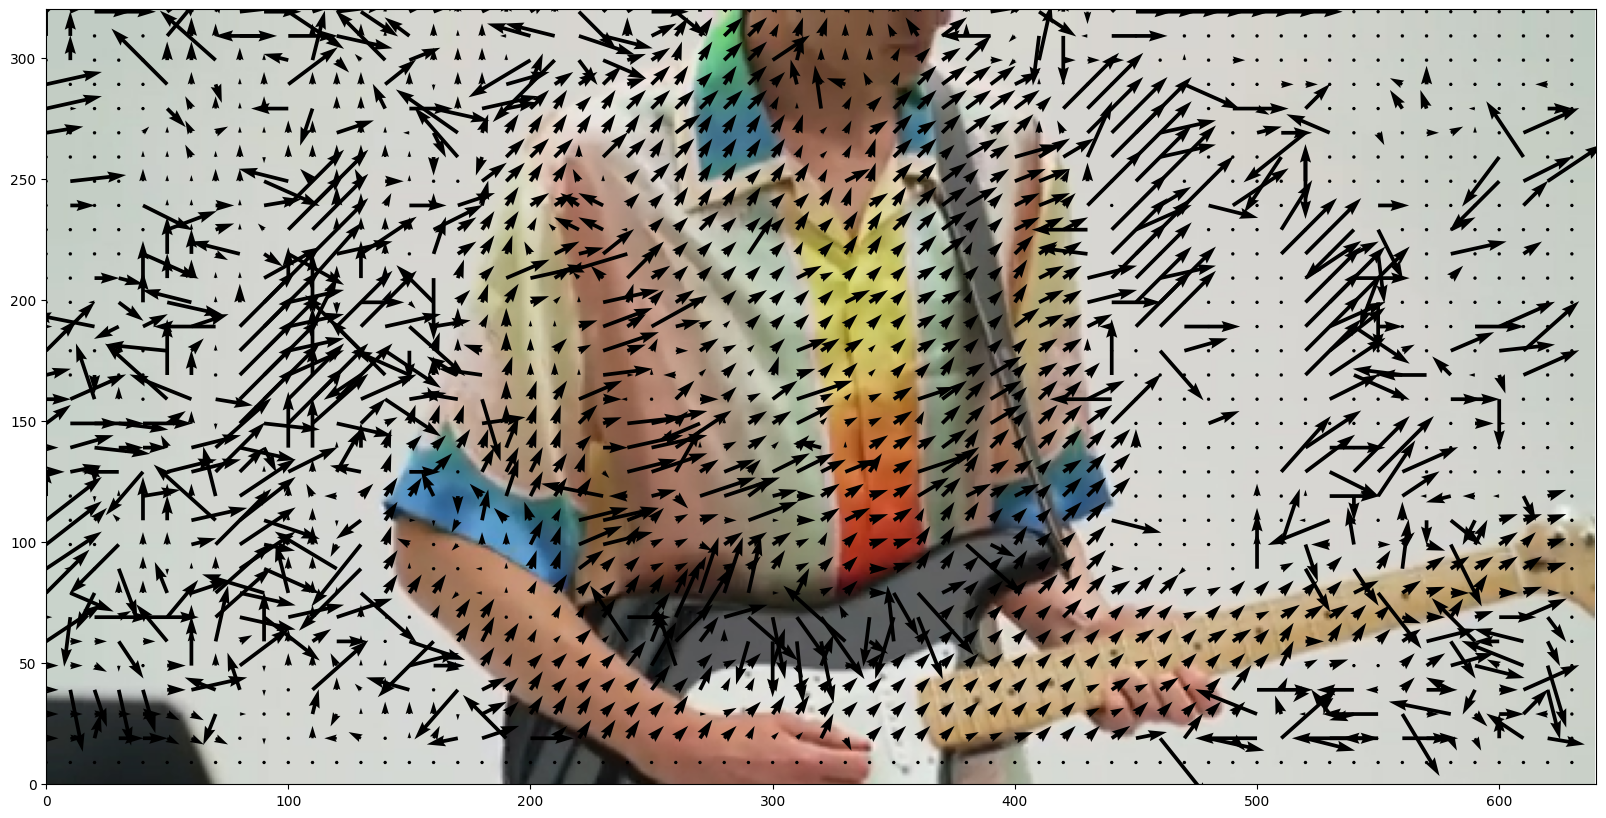

In [83]:
def display_movement_vectors( X,Y, u, v):
    fig, ax = plt.subplots(figsize =(20, 20))
    ax.quiver(X, Y, u, v,scale=250)
    ax.axis([0, frame_array_1.shape[1], 0,frame_array_1.shape[0] ])
    ax.set_aspect('equal')
    plt.imshow(np.flip(frame_array_1,(0)))
    plt.show()

display_movement_vectors(X,Y, u, v)

# (B) Méthode par bloc

In [20]:
def get_block(x,y,frame_array_1,block_size):
    return frame_array_1[x:x+block_size,y:y+block_size]

get_block(5,5,frame_array_1,5).shape

(5, 5, 3)

In [60]:
def get_block_diff_sum(block_a, block_b):
    return (abs((block_a).astype(int) - (block_b).astype(int))).sum()

In [25]:
block_a = get_block(160,160,frame_array_1,5)
block_b = get_block(160,161,frame_array_2,5)
get_block_diff_sum(block_a, block_b)


1937

In [82]:
def get_closer_block(x,y,frame_array_1,frame_array_2,block_size, window_radius):
    block_a = get_block(x,y,frame_array_1,block_size)
    best_coords = max(0,x-window_radius),max(0,y-window_radius)
    best_block = get_block(best_coords[0],best_coords[1],frame_array_2,block_size)
    best_pixel_diff_sum = None
    for current_radius in range(window_radius,-1,-1):
        left_bound,right_bound = max(block_size,x-current_radius),min(x+block_size, frame_array_1.shape[0])
        down_bound,up_bound = max(block_size,y-current_radius),min(y+block_size, frame_array_1.shape[1])
        for curr_x in range(left_bound,right_bound):
            for curr_y in range(down_bound,up_bound):
                if((abs(curr_x-x) + abs(curr_y-y)) != current_radius):
                    continue
                block_b = get_block(curr_x,curr_y,frame_array_2,block_size)
                pixel_diff_sum = get_block_diff_sum(block_a, block_b)
                if(best_pixel_diff_sum is None or pixel_diff_sum <= best_pixel_diff_sum):
                    best_coords = curr_x,curr_y
                    best_block = block_b
                    best_pixel_diff_sum = pixel_diff_sum
    return best_coords


In [75]:
def get_closer_block2(x,y,frame_array_1,frame_array_2,block_size, window_radius):
    block_a = get_block(x,y,frame_array_1,block_size)
    best_coords = max(0,x-window_radius),max(0,y-window_radius)
    best_block = get_block(best_coords[0],best_coords[1],frame_array_2,block_size)
    best_pixel_diff_sum = None
    left_bound,right_bound = max(0,x-window_radius),min(x+window_radius, frame_array_1.shape[0]-block_size)
    down_bound,up_bound = max(0,y-window_radius),min(y+window_radius, frame_array_1.shape[1]-block_size)
    for curr_x in range(left_bound,right_bound):
        for curr_y in range(down_bound,up_bound):
            block_b = get_block(curr_x,curr_y,frame_array_2,block_size)
            pixel_diff_sum = get_block_diff_sum(block_a, block_b)
            if(best_pixel_diff_sum is None or pixel_diff_sum <= best_pixel_diff_sum):
                best_coords = curr_x,curr_y
                best_block = block_b
                best_pixel_diff_sum = pixel_diff_sum
    return best_coords



In [ ]:
block_size = 10
vectors = []
for i in range(0,frame_array_1.shape[0],block_size):
    for j in range(0,frame_array_1.shape[1],block_size):
        vectors.append(get_closer_block2(i,j,frame_array_1,frame_array_2,block_size,5))


In [78]:
def get_move_vector_by_block_wise(x,y,frame_array_1,frame_array_2,block_size, radius):
    new_x,new_y = get_closer_block2(x,y,frame_array_1,frame_array_2,block_size, radius)
    return new_x-x,new_y-y

In [ ]:
def block_wise_func(frame_array_1,frame_array_2,block_size, radius):
    count =0
    u = np.ndarray(shape=frame_array_1.shape[0:2])
    u.fill(0.)
    v = np.ndarray(shape=frame_array_1.shape[0:2])
    v.fill(0.)
    for x in range(0,u.shape[0],block_size):
        for y in range(0,u.shape[1],block_size):
            vector = get_move_vector_by_block_wise(x,y,frame_array_1,frame_array_2,block_size, radius)
            u[x][y]= vector[0]
            v[x][y]= vector[1]
    return u,v
            
    



In [95]:
def get_best_vector(x,y,frame_array_1,frame_array_2,block_size, window_radius):
    if(x+block_size>= frame_array_1.shape[0] or y+block_size>= frame_array_1.shape[1] ):
        return None
    block_a = get_block(x,y,frame_array_1,block_size)
    x_left_bound = max(x-window_radius, 0)
    x_right_bound = min(x+window_radius,frame_array_1.shape[0]-block_size)
    y_bottom_bound = max(y-window_radius,0)
    y_up_bound = min(y+window_radius,frame_array_1.shape[1]-block_size)
    best_coords,best_block = None, None
    best_pixel_diff_sum = None
    best_dist = None
    for curr_x in range(x_left_bound,x_right_bound):
        for curr_y in range(y_bottom_bound,y_up_bound):
            block_b = get_block(curr_x,curr_y,frame_array_2,block_size)
            assert block_b.shape == block_a.shape
            current_dist =  abs(curr_x-x)+abs(curr_y-y)
            pixel_diff_sum = get_block_diff_sum(block_a, block_b)
            if (best_block is None or (pixel_diff_sum <= best_pixel_diff_sum and current_dist <= best_dist)):
                best_coords = curr_x,curr_y
                best_pixel_diff_sum = pixel_diff_sum
                best_block = block_b
                best_dist = current_dist
                continue
            
    return best_coords[0]-x,best_coords[1]-y

assert get_best_vector(318,639,frame_array_1,frame_array_2,block_size, window_radius=20) is None
def test_process_block_wise(frame_array_1,frame_array_2):
    block_size = 10
    stride = 20
    window_radius = 5
    for x in range(0,frame_array_1.shape[0],stride):
        for y in range(0,frame_array_1.shape[1],stride):
            vector = get_best_vector(x,y,frame_array_1,frame_array_2,block_size,window_radius=window_radius)
            assert len(vector) ==2
            assert abs(vector[0]) <= abs(window_radius)
            assert abs(vector[1]) <= abs(window_radius)
test_process_block_wise(frame_array_1,frame_array_2)

In [90]:
def block_wise_func(frame_array_1,frame_array_2,block_size, window_radius):
    count =0
    u = np.ndarray(shape=frame_array_1.shape[0:2])
    u.fill(0.)
    v = np.ndarray(shape=frame_array_1.shape[0:2])
    v.fill(0.)
    for x in range(0,u.shape[0],block_size):
        for y in range(0,u.shape[1],block_size):
            vector = get_best_vector(x,y,frame_array_1,frame_array_2,block_size,window_radius)
            if(vector is None):
                continue
            u[x][y]= vector[0]
            v[x][y]= vector[1]
    return u,v
u,v = block_wise_func(frame_array_1,frame_array_2, block_size=10,window_radius=10)

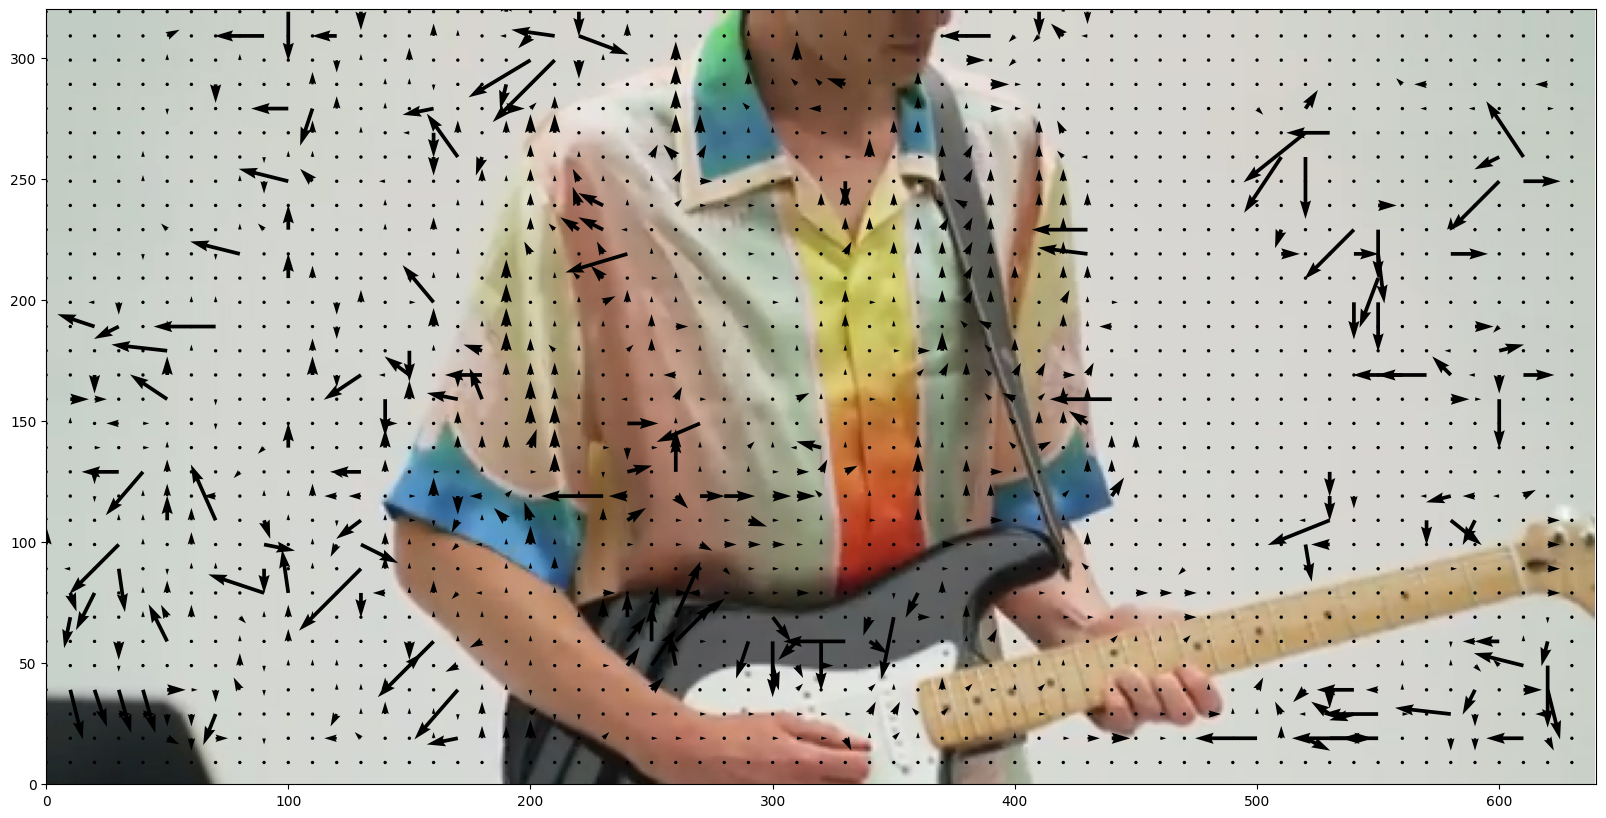

In [129]:
def compute_movement_vectors(frame_array_1,frame_array_2,block_size=10,window_radius=5):
    u,v = block_wise_func(frame_array_1,frame_array_2,block_size, 10)
    u =  u[::block_size,::block_size]
    v = v[::block_size,::block_size]
    x =  np.arange(frame_array_1.shape[1])  
    y = np.arange(frame_array_1.shape[0]-1,-1,-1) 
    X, Y = np.meshgrid(x[::block_size], y[::block_size])
    return X,Y, u, v

X,Y,u,v = compute_movement_vectors(frame_array_1,frame_array_2,block_size=10,window_radius=20)
display_movement_vectors(X,Y, u, v)

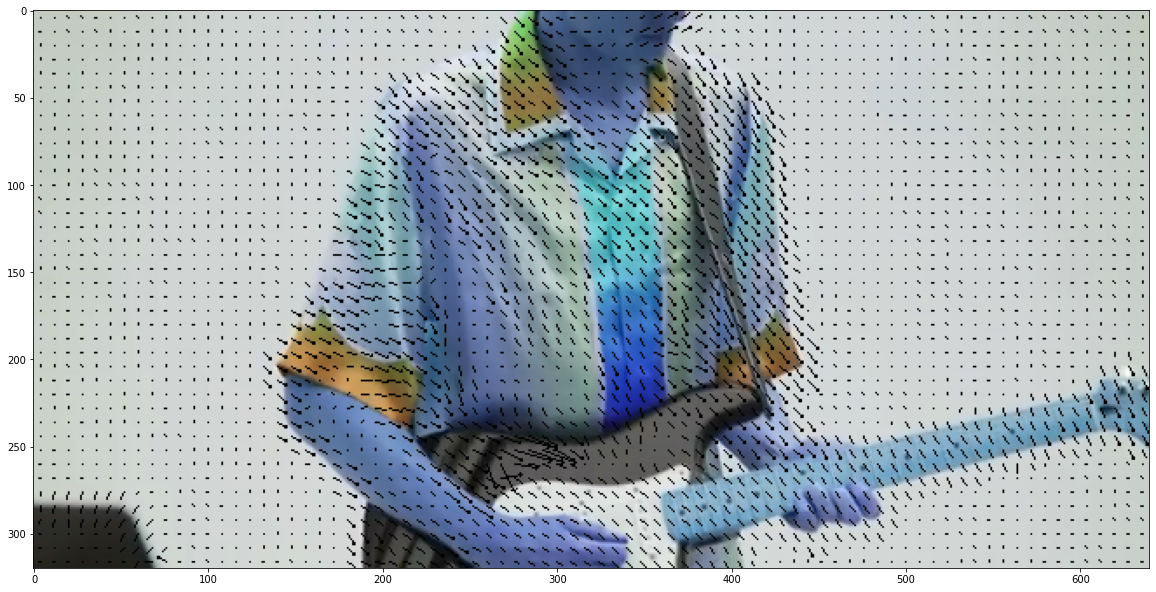

In [6]:
import cv2
import numpy as np
# lire les deux images
img1 = cv2.imread("images/LF016.jpg")
img2 = cv2.imread("images/LF017.jpg")

# convertir les images en niveau de gris
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
# définir la taille des blocs et le pas
block_size = 20
shift_size = 8

# calculer le flux optique avec la méthode block-wise
flow = cv2.calcOpticalFlowFarneback(gray1, gray2, flow=None, pyr_scale =0.5, levels=3, winsize=15, iterations=5, poly_n=5, poly_sigma=1.2, flags=0)

## créer une grille de points pour dessiner les vecteurs de flux
h, w = gray1.shape
grid_y, grid_x = np.mgrid[shift_size//2:h:shift_size, shift_size//2:w:shift_size].reshape(2, -1).astype(int)
points = np.vstack([grid_x, grid_y]).T
#
## dessiner les vecteurs de flux sur l'image 1
fig, ax = plt.subplots(figsize =(20, 20))
for x, y in points:
    dx, dy = flow[y, x]
    dx*=2
    dy*=2
    cv2.arrowedLine(img1, (x, y), (int(x+dx), int(y+dy)), (0, 0, 0))
#
## afficher les images avec les vecteurs de flux dessinés

plt.imshow(img1)
#ax.quiver(grid_x,grid_y, u, v,scale=250)


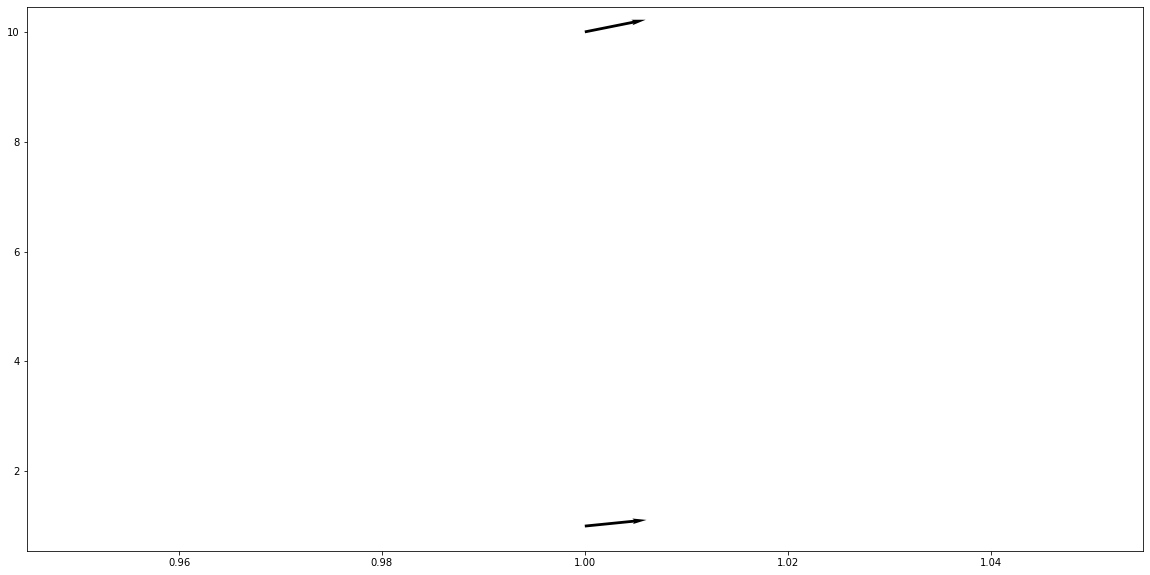

In [81]:
fig, ax = plt.subplots(figsize =(20, 10))
ax.quiver(1,1, 10, 1,headwidth=2,width=0.0025)
ax.quiver(1,10, 10, 2,headwidth=2,width=0.0025)
plt.show()


In [3]:
img1 = Image.open("images/LF016.jpg")

img2 = Image.open("images/LF017.jpg")
# Paramètres de la méthode BMA

block_size = 5 # Taille du bloc
search_area = 16 # Taille de la zone de recherche

# Estimation de mouvement
height, width = frame1.shape
motion_vectors = np.zeros((height//block_size, width//block_size, 2))
fig, ax = plt.subplots(figsize =(20, 10))



for i in range(height//block_size):
    for j in range(width//block_size):
        x = i*block_size
        y = j*block_size
        search_range_x = max(x-search_area, 0)
        search_range_y = max(y-search_area, 0)
        block1 = frame1[x:x+block_size, y:y+block_size]
        best_match = None
        min_diff = float('inf')
        for k in range(search_range_x, min(x+search_area, height-block_size)):
            for l in range(search_range_y, min(y+search_area, width-block_size)):
                block2 = frame2[k:k+block_size, l:l+block_size]
                diff = np.sum(np.abs(block1 - block2))
                if diff < min_diff:
                    min_diff = diff
                    best_match = (k-x, l-y)
        
        motion_vectors[i, j] = best_match
        
plt.show()
# Affichage des vecteurs de mouvement

motion_vectors = motion_vectors.astype(int)
motion_field = np.zeros((height, width, 3))
for i in range(height//block_size):
    for j in range(width//block_size):
        x = i*block_size
        y = j*block_size
        cv2.arrowedLine(motion_field, (y, x), (y+motion_vectors[i, j, 1], x+motion_vectors[i, j, 0]), (255, 255, 255), 1)
Image.fromarray(motion_field.astype(np.uint8)).show()  """
1

SyntaxError: incomplete input (1955490239.py, line 45)

In [56]:
motion_vectors[:,:,0]
motion_vectors[:,:,1]

array([[  0., -25., -50., ..., -10.,   0., -10.],
       [  0., -25., -50., ..., -10.,   0., -10.],
       [  0., -25., -50., ..., -10.,   0., -10.],
       ...,
       [  0.,  40.,  15., ...,   5.,   0., -10.],
       [ 60.,   0.,  65., ..., -10.,   0., -25.],
       [ 75.,  55.,  70., ..., -10.,   0., -25.]])

In [38]:
motion_vectors.shape

(64, 128, 2)